In [39]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
print(tf.__version__)

2.9.1


In [40]:
data_path = "TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [41]:
print("Min Intensity ",data_info.Vmax.min())
print("Min Intensity ",data_info.Vmax.max())
print("Min Intensity ",round(data_info.Vmax.mean(),2))

Min Intensity  15.0
Min Intensity  155.0
Min Intensity  48.14


In [42]:
np.shape(data_matrix)

(4580, 201, 201, 4)

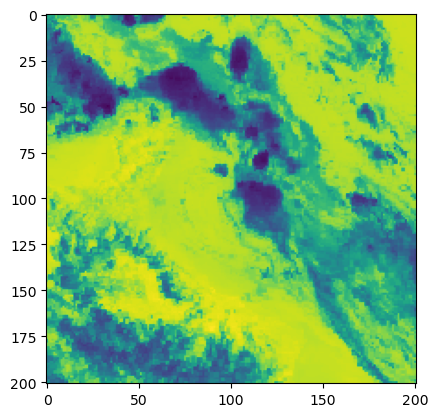

In [43]:
img = data_matrix[150,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img)

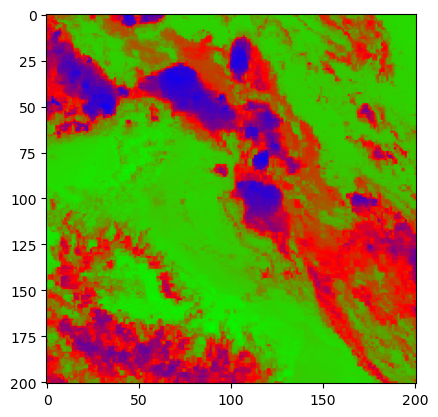

In [44]:
img = data_matrix[150,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.brg)

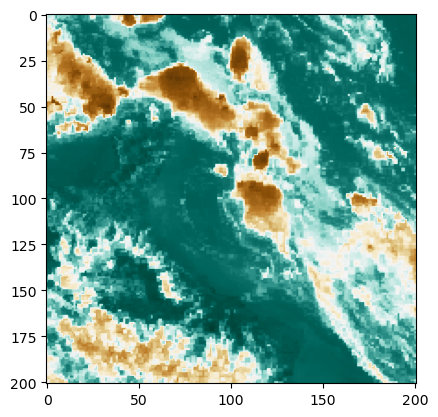

In [45]:
img = data_matrix[150,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.BrBG)

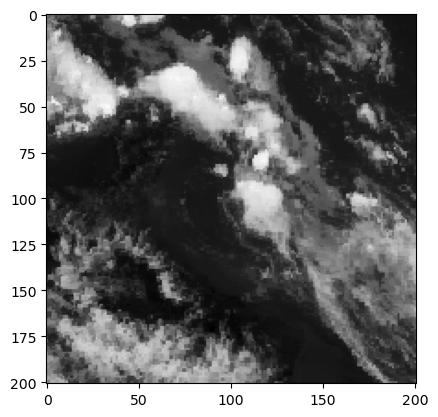

In [46]:
img = data_matrix[150,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.binary)

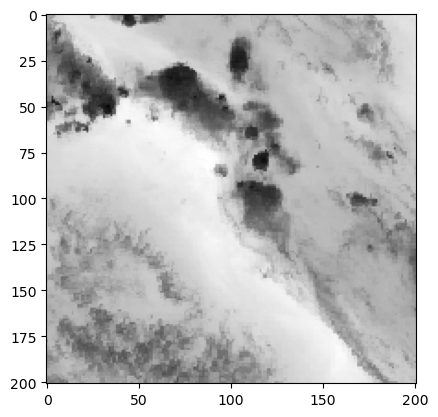

In [47]:
img = data_matrix[150,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [48]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [49]:
print(data_info)

     data_set       ID    lon   lat                time  Vmax  R35_4qAVG  \
0        ATLN  201701L  -50.3  35.8 2017-04-16 06:00:00  55.0      270.0   
1        ATLN  201701L  -49.9  35.5 2017-04-16 09:00:00  55.0      270.0   
2        ATLN  201701L  -49.5  35.1 2017-04-16 12:00:00  55.0      270.0   
3        ATLN  201701L  -49.1  34.8 2017-04-16 15:00:00  55.0      262.5   
4        ATLN  201701L  -48.7  34.4 2017-04-16 18:00:00  55.0      255.0   
...       ...      ...    ...   ...                 ...   ...        ...   
4575     WPAC  201733W  105.0   8.4 2017-12-26 00:00:00  20.0        0.0   
4576     WPAC  201733W  104.7   8.4 2017-12-26 03:00:00  20.0        0.0   
4577     WPAC  201733W  104.4   8.4 2017-12-26 06:00:00  20.0        0.0   
4578     WPAC  201733W  104.0   8.4 2017-12-26 09:00:00  18.0        0.0   
4579     WPAC  201733W  103.6   8.5 2017-12-26 12:00:00  15.0        0.0   

        MSLP  
0      992.0  
1      990.0  
2      989.0  
3      988.0  
4      986.0

In [50]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [51]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

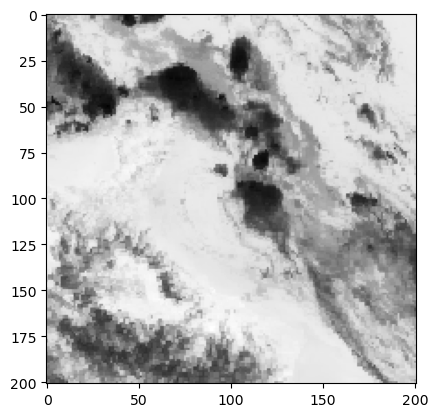

In [52]:
# X_std = tf.image.per_image_standardization(X_irpmw)
img = data_matrix[150,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [53]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

## Alexnet CNN

In [55]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=4,padding='valid', activation='relu', input_shape=(224,224,3)),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='relu'),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )
 
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model

In [56]:
model_history=[]
val_scores=[]
n_epochs=20
batch_size=256
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Epoch 1/20


c:\Users\HP\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15/15 [==============================] - 27s 2s/step - loss: 45801.0703 - mean_squared_error: 45801.0703
Epoch 2/20
15/15 [==============================] - 25s 2s/step - loss: 824.4646 - mean_squared_error: 824.4646
Epoch 3/20
15/15 [==============================] - 26s 2s/step - loss: 798.0815 - mean_squared_error: 798.0815
Epoch 4/20
15/15 [==============================] - 27s 2s/step - loss: 706.3842 - mean_squared_error: 706.3842
Epoch 5/20
15/15 [==============================] - 27s 2s/step - loss: 553.6774 - mean_squared_error: 553.6774
Epoch 6/20
15/15 [==============================] - 28s 2s/step - loss: 493.6864 - mean_squared_error: 493.6864
Epoch 7/20
15/15 [==============================] - 27s 2s/step - loss: 460.9585 - mean_squared_error: 460.9585
Epoch 8/20
15/15 [==============================] - 27s 2s/step - loss: 413.0275 - mean_squared_error: 413.0275
Epoch 9/20
15/15 [==============================] - 28s 2s/step - loss: 387.7852 - mean_squared_error: 387.7852

In [57]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)

print('Test accuracy:', score[1])

13/13 [==============================] - 1s 74ms/step
Testing...
26/26 [==============================] - 1s 41ms/step - loss: 257.3806 - mean_squared_error: 257.3806
Test accuracy: 257.38055419921875


In [58]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

In [59]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [60]:
cate_dataset = list(zip(abcd,cate))

In [61]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])

In [62]:
df

,Intensity,Category
0,52,Tropical Storm
1,29,Tropical Depression
2,24,Tropical Depression
3,53,Tropical Storm
4,30,Tropical Depression
...,...,...
408,42,Tropical Storm
409,30,Tropical Depression
410,31,Tropical Depression
411,25,Tropical Depression


In [32]:
cylone_number = 100 #must be between 0-412

In [33]:
print(f" the cyclone {cylone_number} has the intensity " , df["Intensity"][cylone_number] , " and the category " , df["Category"][cylone_number])

 the cyclone 100 has the intensity  0  and the category  Tropical Depression


## Deep CNN

In [34]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )

    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model


In [35]:
model_history=[]
val_scores=[]
n_epochs=10
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Epoch 1/10


c:\Users\HP\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


58/58 [==============================] - 5s 63ms/step - loss: 3088.4143 - mean_squared_error: 3088.4087
Epoch 2/10
58/58 [==============================] - 4s 67ms/step - loss: 3088.4106 - mean_squared_error: 3088.4087
Epoch 3/10
58/58 [==============================] - 4s 66ms/step - loss: 3088.4092 - mean_squared_error: 3088.4087
Epoch 4/10
58/58 [==============================] - 4s 70ms/step - loss: 3088.4089 - mean_squared_error: 3088.4087
Epoch 5/10
58/58 [==============================] - 4s 69ms/step - loss: 3084.4963 - mean_squared_error: 3084.4963
Epoch 6/10
58/58 [==============================] - 4s 67ms/step - loss: 1315.0068 - mean_squared_error: 1315.0066
Epoch 7/10
58/58 [==============================] - 4s 67ms/step - loss: 958.5846 - mean_squared_error: 958.5845
Epoch 8/10
58/58 [==============================] - 4s 72ms/step - loss: 873.0756 - mean_squared_error: 873.0755
Epoch 9/10
58/58 [==============================] - 4s 69ms/step - loss: 831.9574 - mean_square

In [29]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)
print('Test accuracy:', score[1])

13/13 [==============================] - 0s 8ms/step
Testing...
26/26 [==============================] - 0s 6ms/step - loss: 433.8562 - mean_squared_error: 433.8555
Test accuracy: 433.85546875


In [30]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

In [31]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [32]:
cate_dataset = list(zip(abcd,cate))

In [33]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])

In [34]:
df

,Intensity,Category
0,57,Tropical Storm
1,32,Tropical Depression
2,31,Tropical Depression
3,94,Typhoon
4,47,Tropical Storm
...,...,...
408,49,Tropical Storm
409,35,Tropical Storm
410,35,Tropical Storm
411,35,Tropical Storm


In [55]:
cylone_number = 412 #must be between 0-412

In [56]:
print(f" the cyclone {cylone_number} has the intensity " , df["Intensity"][cylone_number] , " and the category " , df["Category"][cylone_number])

 the cyclone 412 has the intensity  82  and the category  Typhoon


## Kfold 

In [36]:
n_epochs=5
batch_size=32
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y, val_y = y[train_index], y[test_index]
    history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/5
96/96 [==============================] - 4s 37ms/step - loss: 662.7629 - mean_squared_error: 662.7558
Epoch 2/5
96/96 [==============================] - 4s 38ms/step - loss: 521.0094 - mean_squared_error: 521.0037
Epoch 3/5
96/96 [==============================] - 4s 38ms/step - loss: 393.0640 - mean_squared_error: 393.0590
Epoch 4/5
96/96 [==============================] - 3s 36ms/step - loss: 371.7738 - mean_squared_error: 371.7688
Epoch 5/5
48/48 [==============================] - 1s 11ms/step - loss: 496.6913 - mean_squared_error: 496.6862
Val Score:  [496.6912536621094, 496.68621826171875]


Training on Fold:  2
Epoch 1/5
96/96 [==============================] - 5s 40ms/step - loss: 978.9446 - mean_squared_error: 978.9373
Epoch 2/5
96/96 [==============================] - 4s 40ms/step - loss: 831.9252 - mean_squared_error: 831.9191
Epoch 3/5
96/96 [==============================] - 4s 41ms/step - loss: 621.1421 - mean_squared_error: 621.1362
Epoch 4/

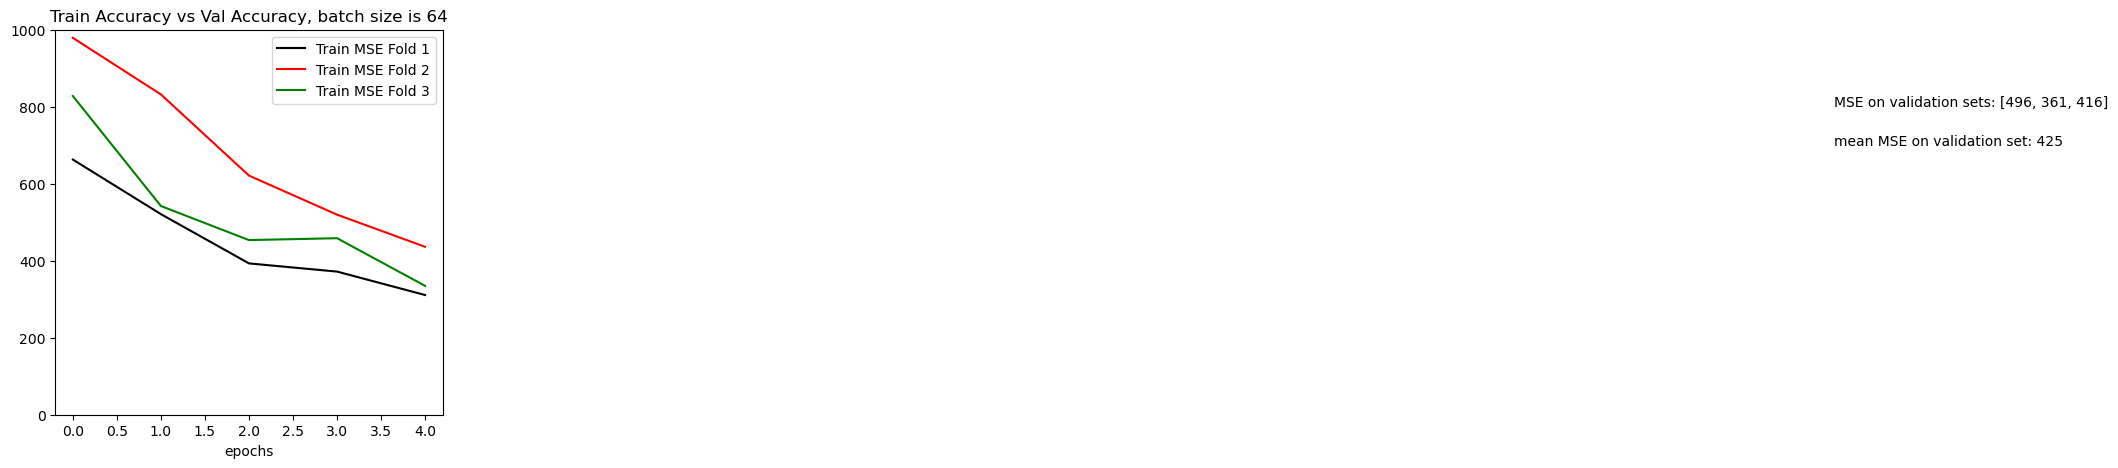

In [37]:
plt.figure(figsize=(5,5))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green']
for i in range(3):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
#     plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()